# Imports

In [ ]:
!pip install -q skforecast dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the Data

In [ ]:
# Function to load the data
def load_and_display_data(url):
    """
    Load and display the initial air pollution data.

    Parameters:
    url (str): The URL to download the data from.

    Returns:
    pd.DataFrame: The initial data.
    """
    # Data download
    data = pd.read_csv(url, sep=',')
    print("Initial data:")
    display(data.head())

    return data

# Use the function
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/guangyuan_air_pollution.csv'
)
initial_data = load_and_display_data(url)

Initial data:


,date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013-03-01,181.0,280.0,204.0,684.0,9600.0,1516.0,1.391667,1026.875000,-18.745833,0.0,3.254167
1,2013-03-02,633.0,837.0,674.0,1495.0,20198.0,844.0,0.616667,1026.850000,-15.937500,0.0,1.479167
2,2013-03-03,1956.0,2858.0,1661.0,2315.0,47195.0,396.0,5.566667,1014.608333,-12.316667,0.0,1.658333
3,2013-03-04,438.0,1007.0,485.0,1232.0,15000.0,1308.0,9.962500,1017.650000,-11.683333,0.0,2.404167
4,2013-03-05,3388.0,3929.0,2001.0,3234.0,59594.0,1891.0,6.291667,1010.900000,-7.525000,0.0,1.129167


In [ ]:
# Function to prepare the data
def prepare_and_display_data(data):
    """
    Prepare and display the air pollution data.

    Parameters:
    data (pd.DataFrame): The initial data.

    Returns:
    pd.DataFrame: The prepared data with 'CO', 'SO2', and 'PM2.5' columns.
    """
    # Data preparation
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data = data.set_index('date')
    data = data.asfreq('D')
    data = data.sort_index()
    data = data[['CO', 'SO2', 'PM2.5']]

    print("Prepared data:")
    display(data.head())

    return data

# Use the function
prepared_data = prepare_and_display_data(initial_data)

Prepared data:


,CO,SO2,PM2.5
date,,,
2013-03-01,9600.0,204.0,181.0
2013-03-02,20198.0,674.0,633.0
2013-03-03,47195.0,1661.0,1956.0
2013-03-04,15000.0,485.0,438.0
2013-03-05,59594.0,2001.0,3388.0


# Split the Data

In [ ]:
# Function to split the data
def split_data(data, end_train=None, test_size=None, test_steps=None):
    """
    Split the data into training and testing sets based on the specified criteria.

    Parameters:
    data (pd.DataFrame): The data to be split.
    end_train (str, optional): The end date for the training set.
    test_size (float, optional): The proportion of the data to be used as the test set (between 0 and 1).
    test_steps (int, optional): The number of time steps to be used as the test set.

    Returns:
    tuple: A tuple containing the training and testing data sets.
    """
    if end_train:
        data_train = data.loc[:end_train, :].copy()
        data_test = data.loc[end_train:, :].copy()
    elif test_size is not None:
        test_steps = int(len(data) * test_size)
        data_train = data.iloc[:-test_steps].copy()
        data_test = data.iloc[-test_steps:].copy()
    elif test_steps is not None:
        data_train = data.iloc[:-test_steps].copy()
        data_test = data.iloc[-test_steps:].copy()
    else:
        raise ValueError("Either end_train, test_size, or test_steps must be specified.")

    print(
        f"Train dates : {data_train.index.min()} --- {data_train.index.max()} "
        f"(n={len(data_train)})"
    )
    print(
        f"Test dates  : {data_test.index.min()} --- {data_test.index.max()} "
        f"(n={len(data_test)})"
    )

    return data_train, data_test

# Use the function with a datetime string
# data_train, data_test = split_data(prepared_data, end_train='2016-05-31 23:59:00')

# Use the function with a fixed number of timesteps
# data_train, data_test = split_data(prepared_data, test_steps=365)

# Use the function with a percentage split
data_train, data_test = split_data(prepared_data, test_size=0.2)

Train dates : 2013-03-01 00:00:00 --- 2016-05-12 00:00:00 (n=1169)
Test dates  : 2016-05-13 00:00:00 --- 2017-02-28 00:00:00 (n=292)


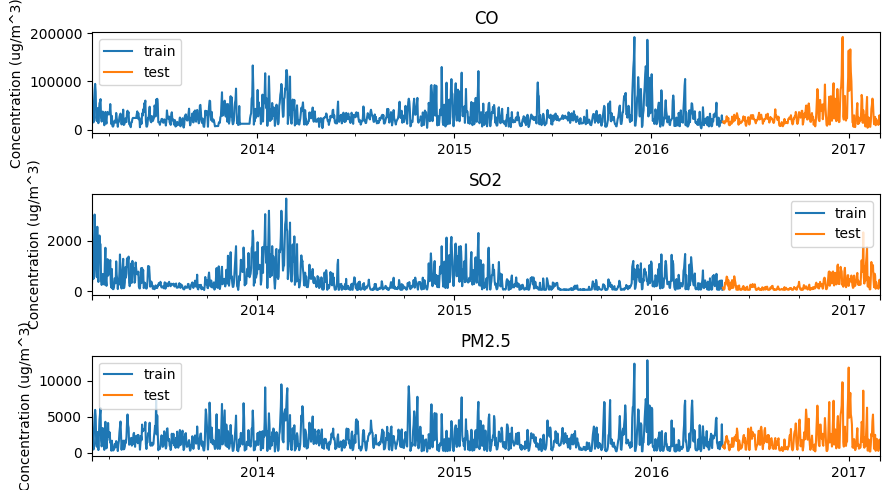

In [ ]:
# Function to plot the time series columns
def plot_time_series(data_train, data_test, columns, ylabel='Concentration (ug/m^3)', figsize=(9, 5)):
    """
    Plot time series data for training and testing sets.

    Parameters:
    data_train (pd.DataFrame): The training data.
    data_test (pd.DataFrame): The testing data.
    columns (list): The list of columns to plot.
    ylabel (str): The label for the y-axis. Default is 'Concentration (ug/m^3)'.
    figsize (tuple): The size of the figure. Default is (9, 5).

    Returns:
    None
    """
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=figsize, sharex=False)

    for i, column in enumerate(columns):
        data_train[column].plot(label='train', ax=axes[i])
        data_test[column].plot(label='test', ax=axes[i])
        axes[i].set_xlabel('')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(column)
        axes[i].legend()

    fig.tight_layout()
    plt.show()

# Use the function
columns_to_plot = ['CO', 'SO2', 'PM2.5']
plot_time_series(data_train, data_test, columns_to_plot)

# Forecaster

In [ ]:
# Function to create and fit the forecaster
def create_and_fit_forecaster(data_train, data_test, level, lags=None, regressor=None, transformer_series=None, transformer_exog=None, weight_func=None, n_jobs='auto', random_state=123):
    """
    Create and fit a ForecasterAutoregMultiVariate model.

    Parameters:
    data_train (pd.DataFrame): The training data.
    data_test (pd.DataFrame): The testing data.
    level (str): The target variable to forecast.
    lags (int, optional): Number of lags to use as predictors. Default is None, will use 7.
    regressor (object, optional): The regressor to use. Default is LGBMRegressor.
    transformer_series (object, optional): Transformer for the series. Default is StandardScaler.
    transformer_exog (object, optional): Transformer for exogenous variables. Default is None.
    weight_func (function, optional): Weight function. Default is None.
    n_jobs (str or int, optional): Number of jobs to run in parallel. Default is 'auto'.
    random_state (int, optional): Random state for the regressor. Default is 123.

    Returns:
    ForecasterAutoregMultiVariate: The fitted forecaster model.
    """
    steps = len(data_test)
    if lags is None:
        lags = 7  # Default to one week of lags for daily data

    if regressor is None:
        regressor = LGBMRegressor(random_state=random_state, verbose=-1)
    if transformer_series is None:
        transformer_series = StandardScaler()

    forecaster = ForecasterAutoregMultiVariate(
        regressor=regressor,
        level=level,
        lags=lags,
        steps=steps,
        transformer_series=transformer_series,
        transformer_exog=transformer_exog,
        weight_func=weight_func,
        n_jobs=n_jobs
    )

    forecaster.fit(series=data_train)
    return forecaster

# Use the function
forecaster = create_and_fit_forecaster(data_train, data_test, level='CO')
print(forecaster)

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 7 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 292 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}

# Predictions

In [ ]:
# Get predictions
y_pred = forecaster.predict()
print("Predictions:")
display(y_pred)

# Get prediction intervals
y_pred_int = forecaster.predict_interval(random_state=42)
print("\nPrediction intervals:")
display(y_pred_int)

Predictions:


,CO
2016-05-13,12970.247397
2016-05-14,17490.232911
2016-05-15,24071.590422
2016-05-16,27109.771407
2016-05-17,30936.970137
...,...
2017-02-24,29303.381003
2017-02-25,26336.954471
2017-02-26,17716.248798
2017-02-27,31305.891891



Prediction intervals:


,CO,CO_lower_bound,CO_upper_bound
2016-05-13,12970.247397,6931.793158,19683.172618
2016-05-14,17490.232911,11027.865643,24527.195045
2016-05-15,24071.590422,17948.798481,31308.409791
2016-05-16,27109.771407,20136.493606,34548.310308
2016-05-17,30936.970137,24814.290006,38655.763363
...,...,...,...
2017-02-24,29303.381003,21028.511927,38999.706547
2017-02-25,26336.954471,19246.763926,33092.006341
2017-02-26,17716.248798,10374.803606,24936.487822
2017-02-27,31305.891891,24581.230762,37055.611292


In [ ]:
# Print date ranges
print("Training data range:", data_train.index.min(), "to", data_train.index.max())
print("Testing data range:", data_test.index.min(), "to", data_test.index.max())
print("Predictions range:", y_pred.index.min(), "to", y_pred.index.max())

Training data range: 2013-03-01 00:00:00 to 2016-05-12 00:00:00
Testing data range: 2016-05-13 00:00:00 to 2017-02-28 00:00:00
Predictions range: 2016-05-13 00:00:00 to 2017-02-28 00:00:00


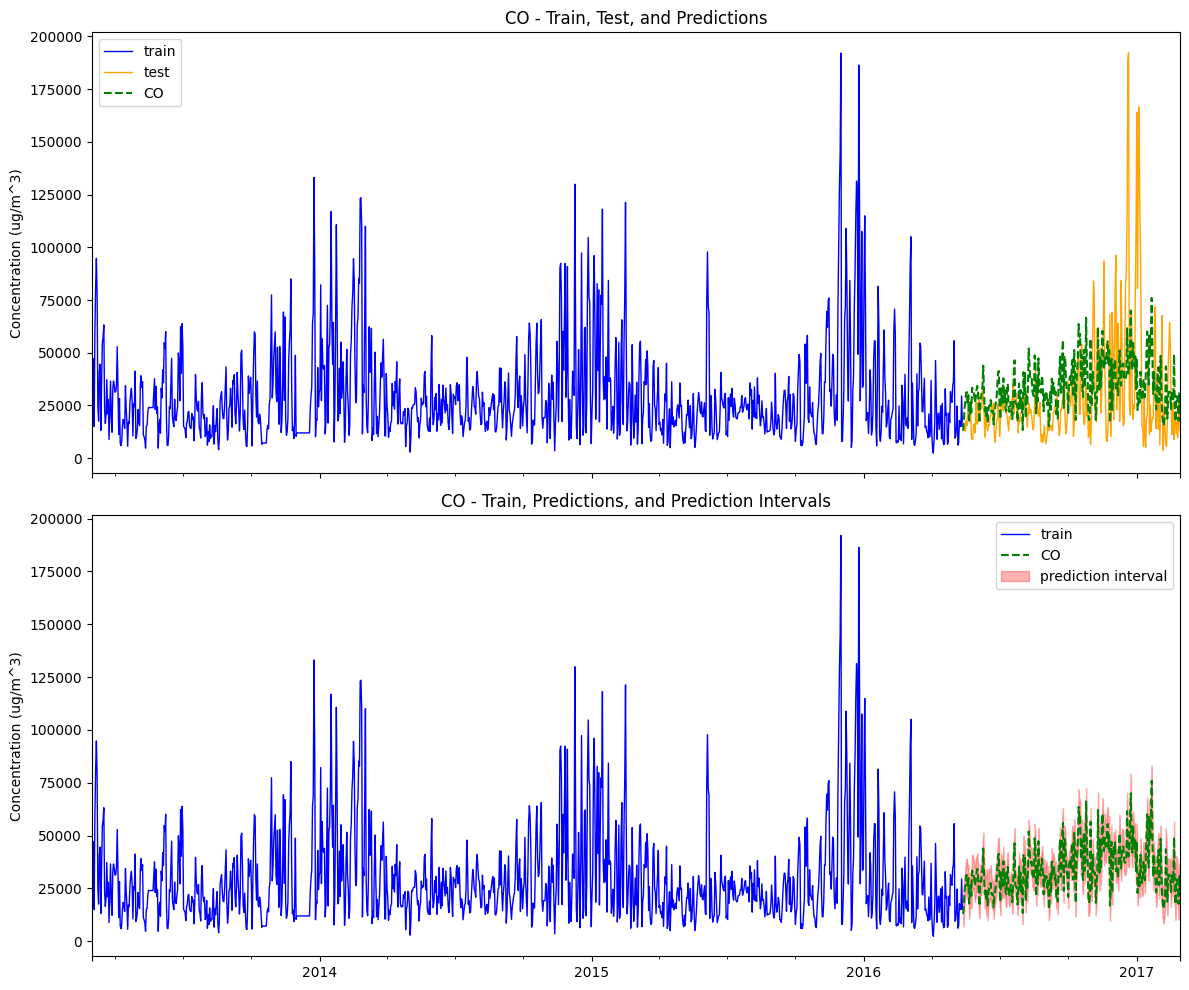

In [ ]:
# Function to plot the predictions
def plot_time_series_with_predictions(data_train, data_test, y_pred, y_pred_int=None, column=None, ylabel='Concentration (ug/m^3)', figsize=(12, 10)):
    """
    Plot time series data for training and testing sets along with predictions and prediction intervals.

    Parameters:
    data_train (pd.DataFrame or pd.Series): The training data.
    data_test (pd.DataFrame or pd.Series): The testing data.
    y_pred (pd.Series): The predicted values for the time series of interest.
    y_pred_int (pd.DataFrame, optional): The prediction intervals for the time series of interest. Default is None.
    column (str, optional): The column of interest if data_train/data_test are DataFrames with more than one column.
                            Default is None.
    ylabel (str): The label for the y-axis. Default is 'Concentration (ug/m^3)'.
    figsize (tuple): The size of the figure. Default is (12, 10).

    Returns:
    None
    """
    if isinstance(data_train, pd.DataFrame) and len(data_train.columns) > 1:
        if column is None:
            raise ValueError("Column name must be specified when data_train/data_test have more than one column.")
        data_train_series = data_train[column]
        data_test_series = data_test[column]
    else:
        data_train_series = data_train
        data_test_series = data_test

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True)

    # Plot training, testing data, and predictions
    data_train_series.plot(label='train', ax=axes[0], color='blue', linewidth=1)
    data_test_series.plot(label='test', ax=axes[0], color='orange', linewidth=1)
    y_pred.plot(label='predicted', ax=axes[0], color='green', linestyle='--', linewidth=1.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel(ylabel)
    axes[0].set_title(f'{column} - Train, Test, and Predictions')
    axes[0].legend()

    # Plot training data, predictions, and prediction intervals
    data_train_series.plot(label='train', ax=axes[1], color='blue', linewidth=1)
    y_pred.plot(label='predicted', ax=axes[1], color='green', linestyle='--', linewidth=1.5)

    if y_pred_int is not None:
        lower_bound_col = f'{column}_lower_bound' if column else 'lower_bound'
        upper_bound_col = f'{column}_upper_bound' if column else 'upper_bound'
        axes[1].fill_between(
            y_pred_int.index,
            y_pred_int[lower_bound_col],
            y_pred_int[upper_bound_col],
            color='red', alpha=0.3,
            label='prediction interval'
        )

    # Set x-axis limits to include the full range of dates
    all_dates = pd.concat([data_train_series, data_test_series, y_pred]).index
    axes[0].set_xlim(all_dates.min(), all_dates.max())
    axes[1].set_xlim(all_dates.min(), all_dates.max())

    axes[1].set_xlabel('')
    axes[1].set_ylabel(ylabel)
    axes[1].set_title(f'{column} - Train, Predictions, and Prediction Intervals')
    axes[1].legend()

    fig.tight_layout()
    plt.show()

# Use the function
plot_time_series_with_predictions(data_train, data_test, y_pred, y_pred_int, column='CO')

# Backtesting

In [ ]:
# Backtesting
metrics_levels, backtest_pred = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=prepared_data,
    steps=len(data_test),
    metric='mean_absolute_error',
    initial_train_size=len(data_train),
    fixed_train_size=False,
    gap=0,
    allow_incomplete_fold=True,
    refit=False,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

print("Backtest metrics:")
display(metrics_levels)

print("\nBacktest predictions:")
display(backtest_pred)

  0%|          | 0/1 [00:00<?, ?it/s]

Backtest metrics:


,levels,mean_absolute_error
0,CO,18688.179727



Backtest predictions:


,CO
2016-05-13,12970.247397
2016-05-14,17490.232911
2016-05-15,24071.590422
2016-05-16,27109.771407
2016-05-17,30936.970137
...,...
2017-02-24,29303.381003
2017-02-25,26336.954471
2017-02-26,17716.248798
2017-02-27,31305.891891


# Tuning

In [ ]:
# Random search
lags_grid = [7, 14, 21]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=3, stop=6, step=1, dtype=int)
}

results = random_search_forecaster_multiseries(
    forecaster=forecaster,
    series=prepared_data,
    exog=None,
    lags_grid=lags_grid,
    param_distributions=param_distributions,
    steps=len(data_test),
    metric='mean_absolute_error',
    aggregate_metric='weighted_average',
    initial_train_size=len(data_train),
    fixed_train_size=False,
    gap=0,
    allow_incomplete_fold=True,
    refit=False,
    n_iter=5,
    return_best=False,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

display(results)

15 models compared for 1 level(s). Number of iterations: 15.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,lags_label,params,mean_absolute_error,n_estimators,max_depth
0,[CO],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'max_depth': 3}",16721.033833,15,3
1,[CO],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 17, 'max_depth': 3}",16732.153861,17,3
2,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'max_depth': 3}",16763.358268,15,3
3,[CO],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 18, 'max_depth': 3}",16787.651249,18,3
4,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 18, 'max_depth': 3}",16835.477020,18,3
5,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 16, 'max_depth': 5}",16845.004089,16,5
6,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 17, 'max_depth': 3}",16860.250966,17,3
7,[CO],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 16, 'max_depth': 5}",16861.299322,16,5
8,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 15, 'max_depth': 3}",16871.929618,15,3
9,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 19, 'max_depth': 5}",16899.372804,19,5


In [ ]:
# Bayesian search
def search_space(trial):
    search_space = {
        'lags': trial.suggest_categorical('lags', [7, 14, 21]),
        'n_estimators': trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),
    }

    return search_space

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster=forecaster,
    series=prepared_data,
    exog=None,
    search_space=search_space,
    steps=len(data_test),
    metric='mean_absolute_error',
    aggregate_metric='weighted_average',
    refit=False,
    initial_train_size=len(data_train),
    fixed_train_size=False,
    n_trials=5,
    random_state=42,
    return_best=False,
    n_jobs='auto',
    verbose=False,
    show_progress=True,
    engine='optuna',
    kwargs_create_study={},
    kwargs_study_optimize={}
)

display(results)

  0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
0,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 10, 'min_samples_leaf': 10, '...",16525.621630,10,10,log2
1,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 11, 'min_samples_leaf': 1, 'm...",16665.631370,11,1,sqrt
2,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'min_samples_leaf': 5, 'm...",16774.523507,15,5,sqrt
3,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'min_samples_leaf': 8, 'm...",16932.688615,15,8,sqrt
4,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'min_samples_leaf': 2, 'm...",17069.151290,16,2,log2


In [ ]:
# Best trial
best_trial

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[16525.62163018949], datetime_start=datetime.datetime(2024, 8, 8, 18, 42, 3, 282491), datetime_complete=datetime.datetime(2024, 8, 8, 18, 42, 8, 825459), params={'lags': 7, 'n_estimators': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(7, 14, 21)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=1, value=None)